In [1]:
import pathlib
import csv

import matplotlib.pyplot as plt

Below is a method for extracting the valid condition names, replicate numbers, file names, and column headers for all of the data located at the directory specified in the path parameter. This can be used to, for example, replicate dictionary(map) style behavior and iterate over the valid "keys" of the dictionary.

In [2]:
def get_structures(path):
    C = []
    R = []
    F = []
    H = {}
    
    conditions = pathlib.Path(path).glob("*")
    for cond_i, condition in enumerate(conditions):
        c = str(condition).split("__")[0].split("/")[-1]
#         if c[0] != 'C': continue
        if 'C' not in c: continue # HACK! the previous line only works when there are no prefix on the cond names
        C.append(c)
        if cond_i == 0:
            replicates = condition.glob("*")
            for rep_i, replicate in enumerate(replicates):
                r = str(replicate).split("/")[-1]
                R.append(r)
                if rep_i == 0:
                    files = replicate.glob("*")
                    for file in files:
                        f = str(file).split("/")[-1].split(".")[0]
                        F.append(f)

                        with open(file, 'r') as dataFile:
                            csvReader = csv.reader(dataFile)
                            for row_i, row_d in enumerate(csvReader):
                                if row_i == 0:
                                    H[f] = row_d
                                    break
    return sorted(C),sorted(R),sorted(F),H


# C,R,F,H = get_structures("../Data/fitness_fns")
# print(C)
# print(R)
# print(F)
# print(H)

Below is a method for accessing data in a similar manner to a dictionary(map) but without loading all of the data into RAM. Instead, the file specified by path+condition+rep+file is loaded and the column specified is extracted and returned.

In [11]:
def get_data(path,cond,rep,file,column): 
    data = []
    key = None
    
    files = pathlib.Path(path).glob("*{}*/{}/{}.csv".format(cond,rep,file)) # added * on front to be compatable
    files = [str(f) for f in files]
    if len(files) == 0:                                                           # with named jobs
        print("Missing file at {} {} {} {}".format(path,cond,rep,file))
        return None
    file = files[0]                                       
    with open(file, 'r') as dataFile:
        csvReader = csv.reader(dataFile)
        for row_i, row_d in enumerate(csvReader):
            if row_i == 0:
                key = row_d.index(column)
                continue
            data.append(row_d[key])
    return list(map(float, data)) # TODO this will blow up if you access a list dataField

# test_x = get_data("../Data/fitness_fns","C00","101","pop","update")
# test_y = get_data("../Data/fitness_fns","C00","101","pop","score_AVE")

Below, the get_data() method is used to load the data necessary to plot each replicate of each condition in the ../Data/fitness_fns directory. From top to bottom, the number of traits is increasing from plot to plot; 1,2,4,8,16. From left to right, the length of the b-period is increasing; 0.25,0.5,0.75,1.0. Within each plot we are showing 50 replicate evolutionary runs. Each run is 100k generations long. Displayed for each replicate is the population average of "score".

shortest rep 1001 longest rep 1001
saving


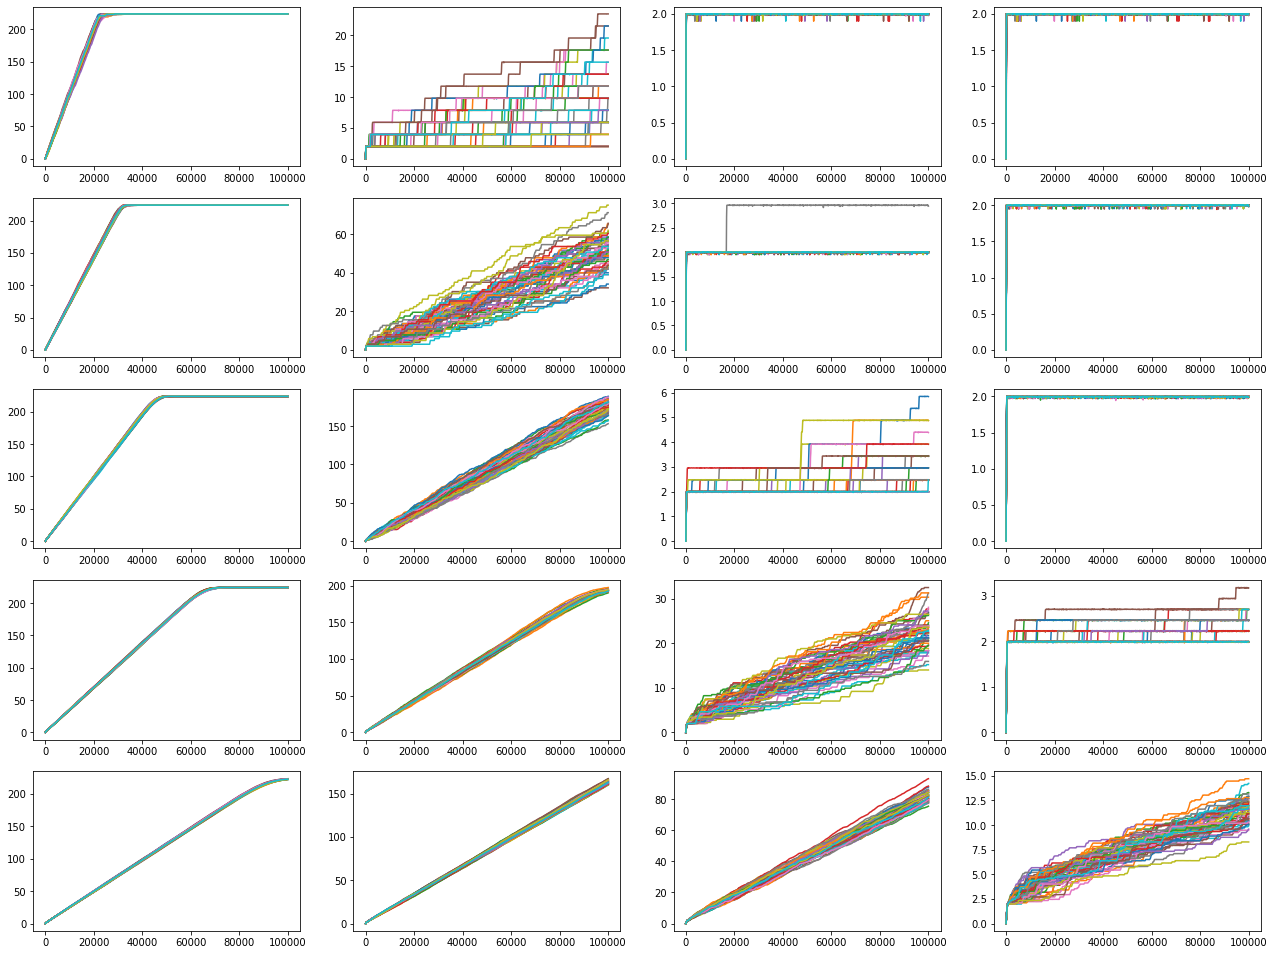

In [4]:
fig, axs = plt.subplots(5,4)
fig.set_size_inches(22, 17)
i = 0
j = 0
lens = []
for c in [str(x).zfill(2) for x in range(20)]:
    for r in range(101,151):
        x = get_data("../Data/fitness_fns","C{}".format(c),r,"LOD_data","update")
        y = get_data("../Data/fitness_fns","C{}".format(c),r,"LOD_data","score_AVE")
        lens.append(len(y))
        axs[j][i].plot(x, y)
#         axs[j][i].set_ylim(0,256)
    i += 1
    if i == 4:
        i = 0
        j += 1
print("shortest rep", min(lens), "longest rep", max(lens))
print("saving")
# plt.savefig("./FIGGIBOI.png")
plt.show()    

Below is identical code from that in the above pannel. The top row of plots show 1 trait while the bottom shows 1 6. Left to right is identical to above. Selection pressure in these plots is 16x stronger than the plots above.

shortest rep 1001 longest rep 1001
saving


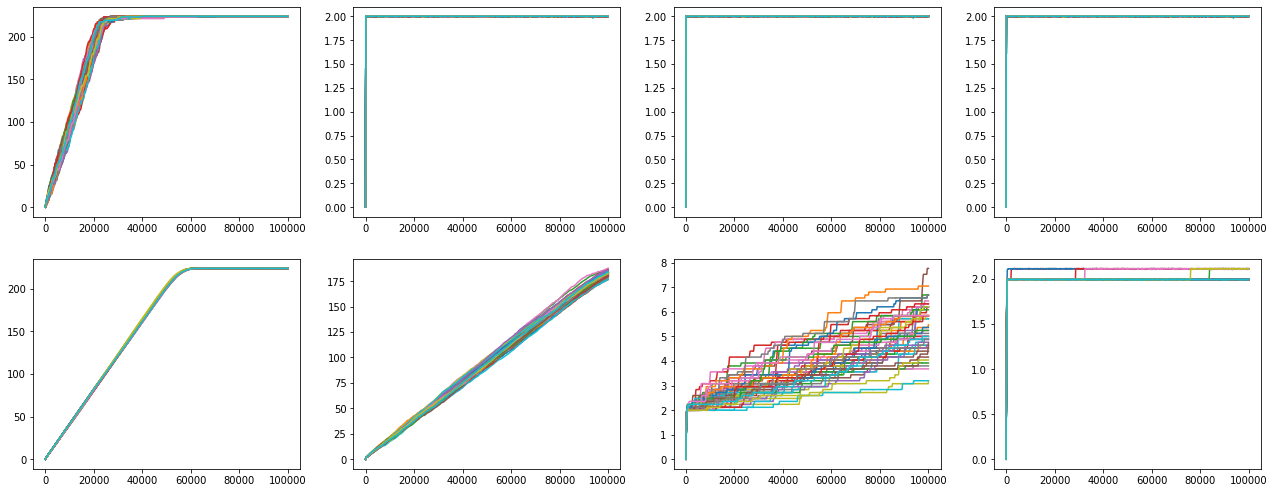

In [5]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(22, 8.5)
i = 0
j = 0
lens=[]
for c in [str(x).zfill(1) for x in range(8)]:
    for r in range(101,151):
        x = get_data("../Data/weak_16_a","C{}".format(c),r,"LOD_data","update")
        y = get_data("../Data/weak_16_a","C{}".format(c),r,"LOD_data","score_AVE")
        lens.append(len(y))
        axs[j][i].plot(x, y)
#         axs[j][i].set_ylim(0,256)
    i += 1
    if i == 4:
        i = 0
        j += 1
print("shortest rep", min(lens), "longest rep", max(lens))
print("saving")
# plt.savefig("./FIGGIBOI2.png")
plt.show()   

The code below compares reducing selection pressure by 16x vs increasing task count from 1 to 16. also with increasing population size by 16.

saving


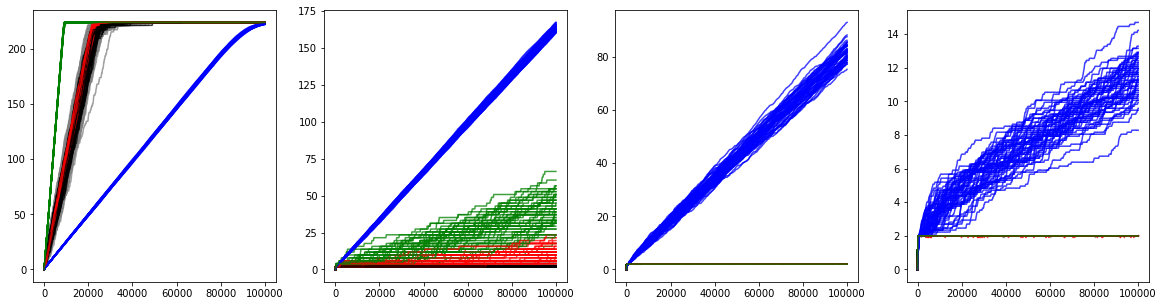

In [6]:
fig, axs = plt.subplots(1,4)
fig.set_size_inches(20, 5)

alpha = 0.75

for c in range(4):
    for r in range(151,601):
        #baseline (aditional reps, total = 16x)
        cc = str(c).zfill(1)
        x = get_data("../Data/more_reps","C{}".format(cc),r,"LOD_data","update")
        y = get_data("../Data/more_reps","C{}".format(cc),r,"LOD_data","score_AVE")
        axs[c].plot(x, y, color="grey",alpha=alpha)
        
    for r in range(101,151):
        #baseline
        cc = str(c).zfill(1)
        x = get_data("../Data/weak_16_a","C{}".format(cc),r,"LOD_data","update")
        y = get_data("../Data/weak_16_a","C{}".format(cc),r,"LOD_data","score_AVE")
        axs[c].plot(x, y, color="black",alpha=alpha)
        
        #weaker selection by 1/16
        cc = str(c).zfill(2)
        x = get_data("../Data/fitness_fns","C{}".format(cc),r,"LOD_data","update")
        y = get_data("../Data/fitness_fns","C{}".format(cc),r,"LOD_data","score_AVE")
        axs[c].plot(x, y,color="red",alpha=alpha)
        
        #16 traits
        cc = str(c+16).zfill(2)
        x = get_data("../Data/fitness_fns","C{}".format(cc),r,"LOD_data","update")
        y = get_data("../Data/fitness_fns","C{}".format(cc),r,"LOD_data","score_AVE")
        axs[c].plot(x, y,color="blue",alpha=alpha)
        
        #16x larger population
        cc = str(c).zfill(1)
        x = get_data("../Data/bigger_pop","C{}".format(cc),r,"LOD_data","update")
        y = get_data("../Data/bigger_pop","C{}".format(cc),r,"LOD_data","score_AVE")
        axs[c].plot(x, y, color="green",alpha=alpha)
        
#         axs[c].set_ylim(0,256)


print("saving")
# plt.savefig("./FIGGIBOI3.png")
plt.show()

Missing file at ../Data/valley_cross cross_time_C01 102 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C01 103 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C01 104 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C01 105 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C01 107 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C01 108 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C01 109 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C02 101 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C02 102 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C02 103 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C02 104 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C02 105 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C02 106 valley_cross_time
Missing file at ../Data/valley_cross c

Missing file at ../Data/valley_cross cross_time_C33 101 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C33 103 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C33 104 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C33 105 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C33 106 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C33 107 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C33 108 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C33 110 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C33 113 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C33 114 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C33 115 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C37 101 valley_cross_time
Missing file at ../Data/valley_cross cross_time_C37 102 valley_cross_time
Missing file at ../Data/valley_cross c

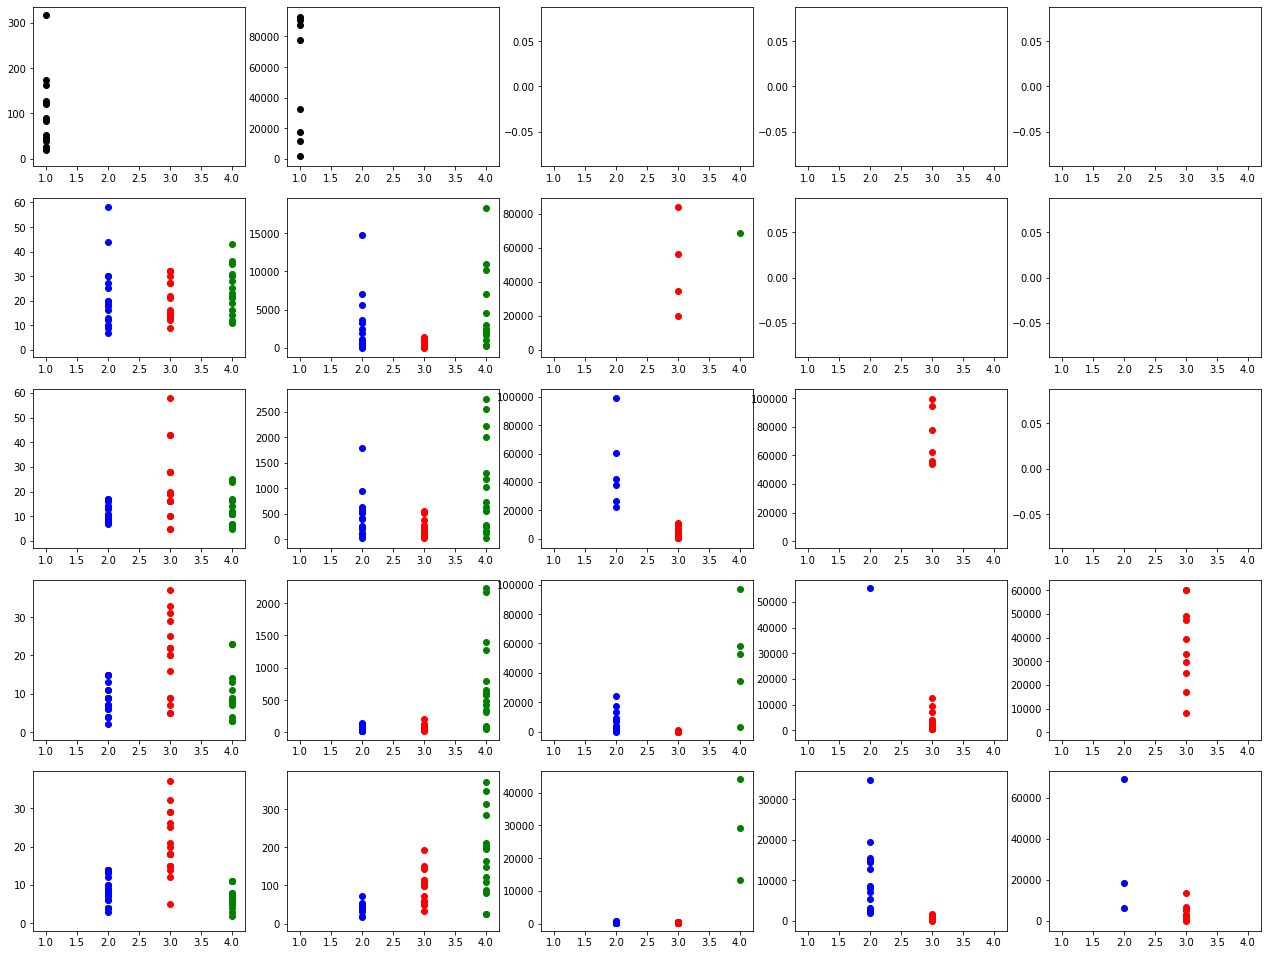

In [25]:
C,R,_,_ = get_structures("../Data/valley_cross")
fig, axs = plt.subplots(5,5)
fx = [1,2,3,4]#,1,2,3,4]
fy = [0,0,0,0]#,100000,100000,100000,100000]
for i in range(5):
    for j in range(5):
        axs[i][j].scatter(fx,fy,alpha=0)
fig.set_size_inches(22, 17)

for ci, c in enumerate(C):
    for r in R:
        y = get_data("../Data/valley_cross",c,r,"valley_cross_time","generation_of_cross")
        if not y is None:
            if ci < 5:
                x = [1 for _ in range(len(y))]
                axs[0][ci].scatter(x,y,color='black')
            elif ci < 9:
                x = [2 for _ in range(len(y))]
                axs[ci-4][0].scatter(x,y,color='blue')
            elif ci < 13:
                x = [2 for _ in range(len(y))]
                axs[ci-8][1].scatter(x,y,color='blue')
            elif ci < 17:
                x = [2 for _ in range(len(y))]
                axs[ci-12][2].scatter(x,y,color='blue')
            elif ci < 21:
                x = [2 for _ in range(len(y))]
                axs[ci-16][3].scatter(x,y,color='blue')
            elif ci < 25:
                x = [2 for _ in range(len(y))]
                axs[ci-20][4].scatter(x,y,color='blue')
            elif ci < 29:
                x = [3 for _ in range(len(y))]
                axs[ci-24][0].scatter(x,y,color='red')
            elif ci < 33:
                x = [3 for _ in range(len(y))]
                axs[ci-28][1].scatter(x,y,color='red')
            elif ci < 37:
                x = [3 for _ in range(len(y))]
                axs[ci-32][2].scatter(x,y,color='red')
            elif ci < 41:
                x = [3 for _ in range(len(y))]
                axs[ci-36][3].scatter(x,y,color='red')
            elif ci < 45:
                x = [3 for _ in range(len(y))]
                axs[ci-40][4].scatter(x,y,color='red')
            elif ci < 49:
                x = [4 for _ in range(len(y))]
                axs[ci-44][0].scatter(x,y,color='green')
            elif ci < 53:
                x = [4 for _ in range(len(y))]
                axs[ci-48][1].scatter(x,y,color='green')
            elif ci < 57:
                x = [4 for _ in range(len(y))]
                axs[ci-52][2].scatter(x,y,color='green')
            elif ci < 61:
                x = [4 for _ in range(len(y))]
                axs[ci-56][3].scatter(x,y,color='green')
            elif ci < 65:
                x = [4 for _ in range(len(y))]
                axs[ci-60][4].scatter(x,y,color='green')
print("saving")
# plt.savefig("./FIGGIBOI4.png")
plt.show()

main_exp_C00
main_exp_C01
main_exp_C02
main_exp_C03
main_exp_C04
main_exp_C05
main_exp_C06
main_exp_C07
main_exp_C08
main_exp_C09
main_exp_C10
main_exp_C11
main_exp_C12
main_exp_C13
main_exp_C14
main_exp_C15
main_exp_C16
main_exp_C17
main_exp_C18
main_exp_C19
main_exp_C20
main_exp_C21
main_exp_C22
main_exp_C23
main_exp_C24
main_exp_C25
main_exp_C26
main_exp_C27
main_exp_C28
main_exp_C29
main_exp_C30
main_exp_C31
main_exp_C32
main_exp_C33
main_exp_C34
main_exp_C35
main_exp_C36
main_exp_C37
main_exp_C38
main_exp_C39
main_exp_C40
main_exp_C41
main_exp_C42
main_exp_C43
main_exp_C44
main_exp_C45
main_exp_C46
main_exp_C47
main_exp_C48
main_exp_C49
main_exp_C50
main_exp_C51
main_exp_C52
main_exp_C53
main_exp_C54
main_exp_C55
main_exp_C56
main_exp_C57
main_exp_C58
main_exp_C59
main_exp_C60
main_exp_C61
main_exp_C62
main_exp_C63
main_exp_C64
saving


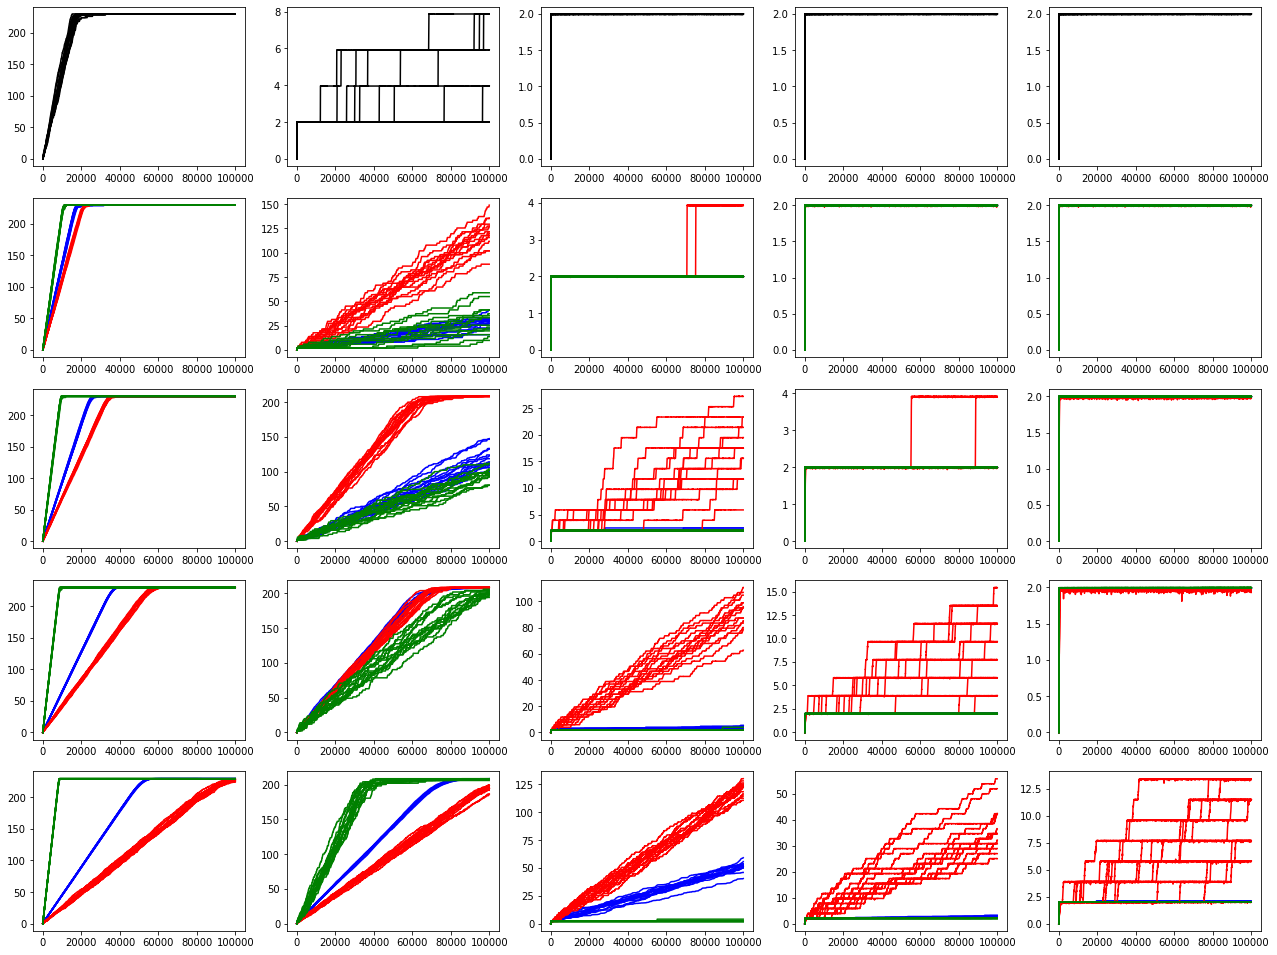

In [21]:
C,R,_,_ = get_structures("../Data/main_exp")
fig, axs = plt.subplots(5,5)
# fx = [1,2,3,4,1,2,3,4]
# fy = [0,0,0,0,100000,100000,100000,100000]
# for i in range(5):
#     for j in range(5):
#         axs[i][j].scatter(fx,fy,alpha=0)
fig.set_size_inches(22, 17)

for ci, c in enumerate(C):
#     if ci > 24: break
#     if ci > 44: break
    print(c)
    for r in R:
        x = get_data("../Data/main_exp",c,r,"pop","update")
        y = get_data("../Data/main_exp",c,r,"pop","score_AVE")
        if not y is None:
            if ci < 5:
                axs[0][ci].plot(x,y,color='black')
            elif ci < 9:
                axs[ci-4][0].plot(x,y,color='blue')
            elif ci < 13:
                axs[ci-8][1].plot(x,y,color='blue')
            elif ci < 17:
                axs[ci-12][2].plot(x,y,color='blue')
            elif ci < 21:
                axs[ci-16][3].plot(x,y,color='blue')
            elif ci < 25:
                axs[ci-20][4].plot(x,y,color='blue')
            elif ci < 29:
                axs[ci-24][0].plot(x,y,color='red')
            elif ci < 33:
                axs[ci-28][1].plot(x,y,color='red')
            elif ci < 37:
                axs[ci-32][2].plot(x,y,color='red')
            elif ci < 41:
                axs[ci-36][3].plot(x,y,color='red')
            elif ci < 45:
                axs[ci-40][4].plot(x,y,color='red')
            elif ci < 49:
                axs[ci-44][0].plot(x,y,color='green')
            elif ci < 53:
                axs[ci-48][1].plot(x,y,color='green')
            elif ci < 57:
                axs[ci-52][2].plot(x,y,color='green')
            elif ci < 61:
                axs[ci-56][3].plot(x,y,color='green')
            elif ci < 65:
                axs[ci-60][4].plot(x,y,color='green')
print("saving")
# plt.savefig("./FIGGIBOI5.png")
plt.show()

In [28]:
def Fa(x):
    return x

def Fb(x):
    return -0.1*x

def C(x, la, lb):
    ca = 0
    cb = 0
    while x >= la+lb:
        ca += 1
        cb += 1
        x -= la+lb
    if x >= la:
        ca += 1
        x -= la
    return ca, cb, x

def F(x):
    la = 2
    lb = 0.4
    ca, cb, d = C(x, la, lb)
    if ca == cb:
        return Fa(ca*la + d) + Fb(cb*lb)
    else:
        return Fa(ca*la) + Fb(cb*lb + d)

In [36]:
x = [1.9, 2.0,2.1,2.2,2.3,2.4, 2.5]
for i in x:
    print(i, F(i))

1.9 1.9
2.0 2.0
2.1 1.99
2.2 1.98
2.3 1.97
2.4 1.96
2.5 2.06


In [40]:
f1 = [2.000000,2.000000,1.990000,2.000000,2.000000,1.990000,2.000000,2.000000,2.000000,2.000000,1.990000,1.990000,1.990000,2.000000,1.990000,2.000000,2.000000,1.990000,2.000000,2.000000,2.000000,2.000000,1.990000,1.990000,2.000000,1.990000,2.000000,1.990000,2.000000,1.990000,1.990000,1.990000,1.990000,2.000000,2.000000,1.990000,1.990000,1.990000,1.990000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.990000,2.000000,1.990000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.990000,2.000000,2.000000,1.990000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.990000,1.990000,1.990000,1.990000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.900000,2.000000,1.990000,2.000000,2.000000,2.000000,2.060000,2.000000,2.000000,2.000000,2.000000,1.990000,2.000000,2.000000,1.960000,2.000000,2.000000,1.900000,2.000000,2.000000,2.000000,2.000000]
f2 = [1.993125,1.983750,1.965000,1.971250,1.998125,1.976250,1.976250,1.970625,1.991875,1.975625,1.981875,1.970625,1.984375,1.976875,1.977500,1.981875,1.983125,1.976250,1.988125,1.965625,1.982500,1.978750,1.978125,1.970000,1.965000,1.971875,1.981250,1.976250,1.960000,1.987500,1.994375,1.965625,1.983750,1.989375,1.971250,1.959375,1.977500,1.982500,1.975625,1.993125,1.982500,1.963125,1.966250,1.983750,1.992500,1.971875,1.972500,1.960000,1.965625,1.959375,1.983750,1.988750,1.994375,1.976250,1.970625,1.983125,1.982500,1.988750,1.992500,1.983125,1.983125,1.978750,1.971250,1.988750,1.983125,1.978125,1.968750,1.957500,1.978750,1.989375,1.959375,1.978750,1.983750,1.990625,1.953125,1.965625,1.970625,1.978125,1.988750,1.984375,1.983125,1.979375,1.965625,1.985625,1.990625,1.989375,1.971250,1.976875,1.989375,1.964375,1.983125,1.978125,1.985000,1.990000,1.983750,1.976250,1.987500,1.989375,1.986250,1.991875]


fm = min(f1)
fM = max(f1)

fnew = [(j-fm)/(fM-fm) for j in f1]
print(sorted(fnew))

fm = min(f2)
fM = max(f2)

fnew = [(j-fm)/(fM-fm) for j in f2]
print(sorted(fnew))

[0.0, 0.0, 0.375, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 1.0]
[0.0, 0.09722222222222276, 0.1388888888888911, 0.1388888888888911, 0.1388888888888911, 0.15277777777777724, 0.15277777777777724, 0.22222222222222276, 0.25, 0.26388888888889106, 0.26388888888889106, 0.27777777777777724, 0.27777777777777724, 0.27777777777777724, 0.2777777777777